In [1]:
import os, sys
project_root_dir = os.path.join(os.getcwd(),'../..')
if project_root_dir not in sys.path:
    sys.path.append(project_root_dir)

from matplotlib import pyplot as plt
import numpy as np
from torch import nn
import torch
import config

from utils import show_abundance, plot_endmembers
from HySpecLab.metrics import rmse, sad
from scipy import io as sio

In [7]:
from dataset import Samson

dataset = Samson(config.Samson_PATH)
result_path = os.path.join(config.RESULTS_PATH, 'samson')

# Ground Truth

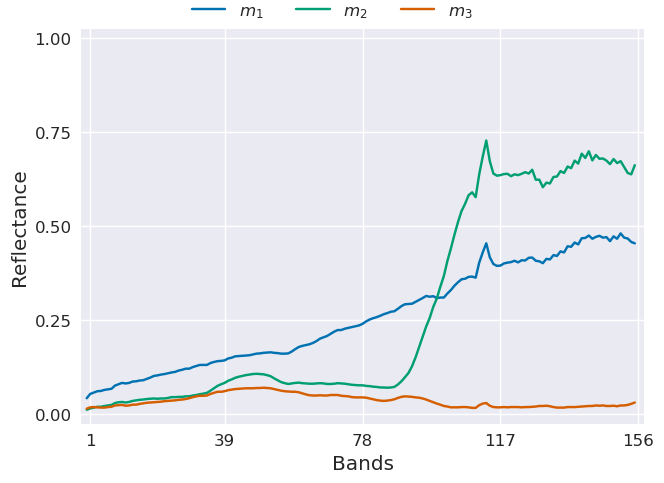

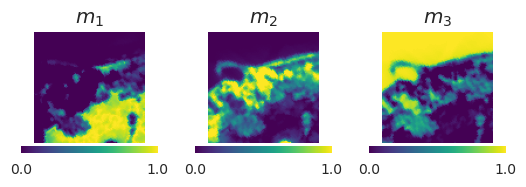

In [8]:
from utils import plot_endmembers, show_abundance
fig = plot_endmembers(dataset.endmembers(), ticks_range=(0, 1))
plt.show(fig)
# fig.savefig(os.path.join(result_path, 'imgs/M_ref.pdf'), bbox_inches='tight')

fig = show_abundance(dataset.abundance())
plt.show(fig)
# fig.savefig(os.path.join(result_path, 'imgs/A_ref.png'), dpi=300, bbox_inches='tight')

In [9]:
from HySpecLab.metrics import sad

def sort_endmember(endmembers, gt):
    sad_result = sad(endmembers, gt)
    e_idx = torch.argmin(sad_result, dim=0) # Index for reordering the ground truth
    return e_idx, sad_result

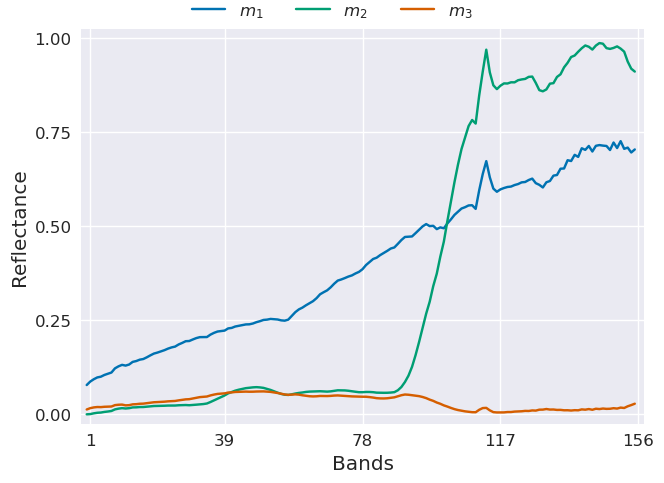

In [10]:
from HySpecLab.eea import VCA

n_endmembers = dataset.n_endmembers
   
vca = VCA(n_endmembers, snr_input=1, random_state=42)
vca.fit(dataset.X.numpy())
endmembers = torch.from_numpy(vca.endmembers()).float()
e_idx, sad_result = sort_endmember(endmembers, dataset.endmembers())

vca_endmember_init = endmembers[e_idx]
vca_logit_endmember_init = torch.log((vca_endmember_init + 1e-12) / ((1-vca_endmember_init) + 1e-12))

fig = plot_endmembers(vca_endmember_init, ticks_range=(0, 1))
plt.show(fig)

# fig.savefig(os.path.join(result_path, 'imgs/M_vca.pdf'), bbox_inches='tight')

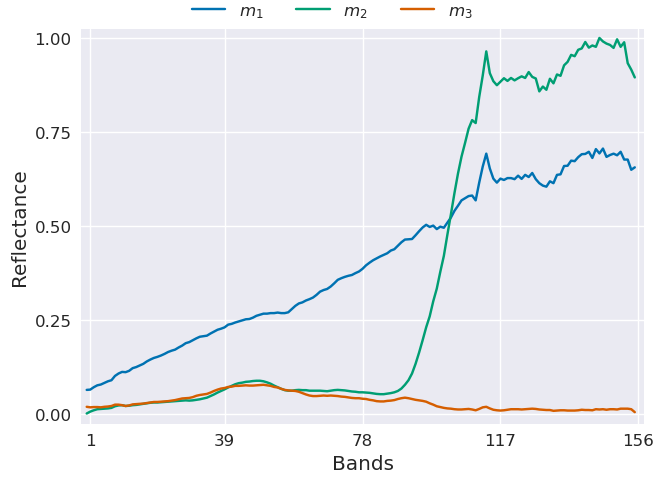

In [11]:
from utils import plot_endmembers
from pysptools import eea
n_endmembers = dataset.n_endmembers 

ee = eea.NFINDR()
endmember = torch.from_numpy(ee.extract(dataset.image(), n_endmembers)).float()

e_idx, _ = sort_endmember(endmember, dataset.endmembers())
nfindr_endmember_init = endmember[e_idx]
nfindr_logit_endmember_init = torch.log((nfindr_endmember_init + 1e-12) / ((1-vca_endmember_init) + 1e-12))

fig = plot_endmembers(nfindr_endmember_init, ticks_range=(0, 1))
plt.show(fig)
# fig.savefig(os.path.join(result_path, 'imgs/M_nfindr.pdf'), bbox_inches='tight')

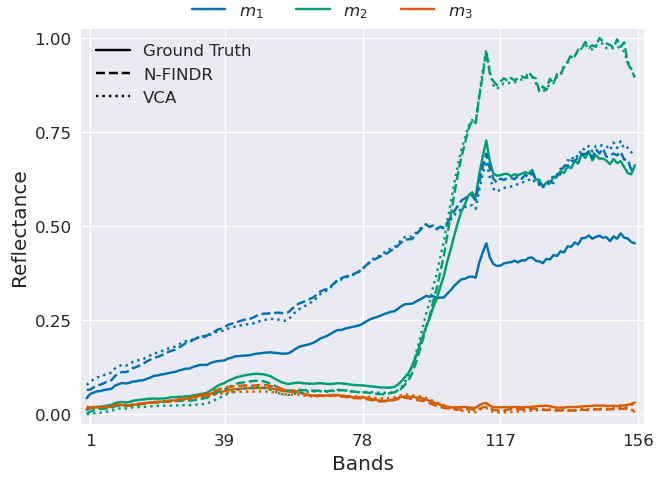

In [12]:
fig = plot_endmembers(dataset.endmembers(), ticks_range=(0, 1), endmember_estimation=[nfindr_endmember_init, vca_endmember_init], ee_labels=['Ground Truth', 'N-FINDR', 'VCA'])
plt.show(fig)
# fig.savefig(os.path.join(result_path, 'imgs/M_estimation.pdf'), bbox_inches='tight')

In [13]:
# endmembers_dict = {'NFINDR': nfindr_endmember_init.numpy(), 'VCA': vca_endmember_init.numpy()}

# sio.savemat(os.path.join(result_path, 'matlab/endmember_estimation.mat'), endmembers_dict)

In [1097]:
# endmember_init_method = 'nfindr'
# endmember_init = nfindr_endmember_init
# logit_endmember_init = nfindr_logit_endmember_init

endmember_init_method = 'vca'
endmember_init = vca_endmember_init
logit_endmember_init = vca_logit_endmember_init

In [1268]:
import numpy as np
import torch

from torch.nn import Parameter
from torch.nn import functional as F

    
class GaussianSparseness(nn.Linear):
    def __init__(self, in_features: int, sigma:float=.5) -> None:
        super(GaussianSparseness, self).__init__(in_features, 1, True)
        self.sigma = sigma
        self.__mu = None
        self.bias.data.fill_(0)

    def forward(self, x):
        self.__mu = F.sigmoid(F.linear(x, self.weight, self.bias)) 
        eps = torch.normal(0, torch.ones_like(self.__mu))
        prob = self.__mu + (self.sigma * eps * self.training)
        return F.hardtanh(prob, 0, 1)
    
    def regularize(self):
        r'''
            The expected regularization is the sum of the probabilities 
            that the gates are active
        '''
        # return torch.mean(self._guassian_cdf(1-self.__mu, self.sigma))
        return torch.mean(self._guassian_cdf(self.__mu, self.sigma))
        
    def _guassian_cdf(self, mu:torch.Tensor, sigma:float) -> torch.Tensor:
        r''' 
            Guassian CDF
            
            Based on: https://stackoverflow.com/questions/809362/how-to-calculate-cumulative-normal-distribution

            Parameters
            ----------
            mu: torch.Tensor, shape (in_features,)
                The mean of the Guassian
            
            sigma: float
                The standard deviation of the Guassian
        '''
        return .5 * (1 + torch.erf(mu / (sigma*np.sqrt(2))))
    
    def variational_parameter(self):
        return self.__mu
    
    def __repr__(self):
        return f'GaussianSparseness(in_features={self.in_features}, sigma={self.sigma:.2f})'

In [1269]:
import torch 
import torch.nn as nn
from torch.nn import Parameter
from torch.nn.functional import softmax, normalize

from collections import deque
from itertools import islice

def lmm(A: torch.Tensor, E: torch.Tensor) -> torch.Tensor:
    '''
        Linear Mixing Model, linear combination of endmembers.

        Args:
        -----
            A: Tensor, shape (bs, n_endmembers)
                Abundance matrix of the linear mixing model.
            E: Tensor, shape (n_endmembers, n_bands)
                Endmembers.
    '''
    bs, _ = A.shape
    return torch.bmm(A.unsqueeze(1), E.unsqueeze(0).expand(bs, -1, -1)).squeeze()

## General
def slide(iterable, size):
    '''
        Iterate through iterable using a sliding window of several elements.
        Important: It is a generator!.
        
        Creates an iterable where each element is a tuple of `size`
        consecutive elements from `iterable`, advancing by 1 element each
        time. For example:
        >>> list(sliding_window_iter([1, 2, 3, 4], 2))
        [(1, 2), (2, 3), (3, 4)]
        
        source: https://codereview.stackexchange.com/questions/239352/sliding-window-iteration-in-python
    '''
    iterable = iter(iterable)
    window = deque(islice(iterable, size), maxlen=size)
    for item in iterable:
        yield tuple(window)
        window.append(item)
    if window:  
        # needed because if iterable was already empty before the `for`,
        # then the window would be yielded twice.
        yield tuple(window)

class ContrastiveUnmixing(nn.Module):
    def __init__(self, n_bands, n_endmembers, encode_layers=[512, 128, 32], endmember_init=None, sparsity=.5) -> None:
        super(ContrastiveUnmixing, self).__init__()      
        encode_layers = [n_bands] + encode_layers
        self.n_endmembers = n_endmembers
        # Encoder
        encoder = []
        for idx, test in enumerate(slide(encode_layers, 2)):
            encoder.append(self.__encode_layer(*test, dropout=True if idx < len(encode_layers)-2 else False))
        self.encoder = nn.Sequential(*encoder)

        # Endmember bank
        self.ebk = Parameter(torch.randn(n_endmembers, n_bands))
        if endmember_init is not None:
            self.ebk.data = endmember_init

        self.sparse_gate = GaussianSparseness(encode_layers[-1], sigma=sparsity)

        # Projection layer
        self.projection = nn.Linear(encode_layers[-1], n_bands, bias=False)

        self.A = None

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        z = self.encoder(input)
        r0 = self.projection(z)
        sparse = self.sparse_gate(z)

        self.A = self.__similarity(r0, sparse)
        return lmm(softmax(self.A, dim=1), torch.sigmoid(self.ebk))

    def __encode_layer(self, in_features, out_features, dropout=False):
        return nn.Sequential(
            nn.Linear(in_features, out_features),
            nn.BatchNorm1d(out_features),
            *[nn.ReLU(), nn.Dropout(0.5)] if dropout else [nn.Identity()]
        )

    def __similarity(self, X: torch.Tensor, sparse:torch.Tensor) -> torch.Tensor:
        '''
            Cosine similarity between input and endmember bank.

            Parameters
            ----------
                x: torch.Tensor, shape=(batch_size, n_bands)
                    input tensor.         
        '''
        bs, n_bands = X.shape
        X = normalize(X, dim=1)

        normalize_ebk = normalize(self.ebk.detach(), dim=1).expand(bs, -1, -1)
        cos = torch.bmm(X.view(bs, 1, n_bands), torch.transpose(normalize_ebk, 1, 2)).squeeze()
        v = (cos*.5) + .5
        eps = 1e-12
        return (1 + eps)/(sparse + eps)*torch.log(v/ (1-v))

        # return torch.exp(self.sparse_gate(self.sparse))*torch.log(v/ (1-v))
        # return torch.pow(self.n_endmembers, self.sparse_gate(self.sparse))*torch.log(v/ (1-v))
        # return self.sparse*torch.exp(v)*torch.log(v/ (1-v))
    
    

In [1270]:
from HySpecLab.metrics.regularization import SimplexVolumeLoss, SimilarityLoss
from HySpecLab.metrics import UnmixingLoss
from torch.utils.data import Dataset, DataLoader
from torch import sigmoid, nn
from tqdm import tqdm
import torch

def train(model:nn.Module, n_endmembers:int, dataset:Dataset, n_batchs:int = 64, n_epochs:int = 100, lr=1e-3, similarity_weight=1, sparse_weight=1e-1):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)
    model.train()

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    criterion = UnmixingLoss() 
    similarity_reg = SimilarityLoss(n_endmembers, temperature=.1, reduction='mean')

    dataloader = DataLoader(dataset, batch_size=int(len(dataset)/n_batchs), shuffle=True)

    epoch_iterator = tqdm(
            range(n_epochs),
            leave=True,
            unit="epoch",
            postfix={"tls": "%.4f" % -1},
        )


    for _ in epoch_iterator:
        epoch_loss = 0.
        for i, (x) in enumerate(dataloader):
            x = x.to(device)
            optimizer.zero_grad()
            y = model(x)
            loss = criterion(y, x) + similarity_weight*similarity_reg(model.ebk) +  sparse_weight*model.sparse_gate.regularize()
            # loss = criterion(y, x) + similarity_weight*similarity_reg(model.ebk)
            epoch_loss += loss.detach().item()

            loss.backward()
            optimizer.step()

        epoch_iterator.set_postfix(tls="%.4f" % (epoch_loss/(i+1)))

# Training

In [1271]:
# from utils import train 
# from HySpecLab.unmixing import ContrastiveUnmixing

n_bands = dataset.n_bands
# model = ContrastiveUnmixing(n_bands, n_endmembers, endmember_init=logit_endmember_init)
model = ContrastiveUnmixing(n_bands, n_endmembers, endmember_init=logit_endmember_init, sparsity=.5)
# model = ContrastiveUnmixing(n_bands, n_endmembers, endmember_init=logit_endmember_init, sparsity=3)
train(model, n_endmembers, dataset, n_batchs=50, n_epochs=50, lr=1e-3, similarity_weight=1, sparse_weight=1)

  0%|          | 0/50 [00:00<?, ?epoch/s, tls=-1.0000]

100%|██████████| 50/50 [00:07<00:00,  6.32epoch/s, tls=0.8252]


In [1272]:
model.eval()
print(model.sparse_gate.variational_parameter().flatten().detach())
print(model.sparse_gate.variational_parameter().flatten().detach().mean())

tensor([4.7919e-05, 2.1030e-02, 3.8023e-01, 9.9056e-01, 1.0000e+00, 1.3663e-03,
        3.9465e-07, 9.9949e-01, 1.0000e+00, 7.8459e-07, 8.7069e-01, 4.0445e-05,
        5.1311e-07, 4.5057e-05, 7.1984e-04, 9.9976e-01, 2.3928e-04, 3.0922e-06,
        1.3888e-03, 1.0000e+00, 4.4658e-03, 6.2103e-04, 3.2305e-03, 9.9995e-01,
        3.3418e-05], device='cuda:0')
tensor(0.3310, device='cuda:0')


# Save model

In [1273]:
# torch.save(model.state_dict(), os.path.join(result_path, 'clhu/weights/clhu.pth'))

# Testing model

In [1292]:
# from HySpecLab.unmixing import ContrastiveUnmixing

# load model
# model = ContrastiveUnmixing(dataset.n_bands, dataset.n_endmembers)

# model.load_state_dict(torch.load(os.path.join(result_path, 'clhu/weights/clhu.pth')))
model = model.eval()

In [1293]:
from HySpecLab.metrics.regularization import SimplexVolumeLoss, SimilarityLoss
from HySpecLab.metrics import UnmixingLoss, NormalizedEntropy

criterion = UnmixingLoss()
entropy_reg  = NormalizedEntropy(S=n_endmembers)
volume_reg = SimplexVolumeLoss(dataset[:], n_endmembers)
similarity_reg = SimilarityLoss(n_endmembers, temperature=.1, reduction='mean')

In [1294]:
# model.sparse = 10

In [1295]:
from torch import sigmoid 
_X = dataset.X

model.eval()
model = model.cpu()
reconstruc = model(_X)
with torch.no_grad():
    print(criterion(reconstruc, _X).cpu(), entropy_reg(model.A).cpu(), volume_reg(sigmoid(model.ebk)).cpu(),
         similarity_reg(model.ebk).cpu())
        #  similarity_reg(sigmoid(model.ebk)).cpu())

tensor(0.1388) tensor(0.2377) tensor(10.6584) tensor(0.0304)


In [1296]:
volume_reg(endmember_init), similarity_reg(logit_endmember_init)

(tensor(59.2881), tensor(0.1501))

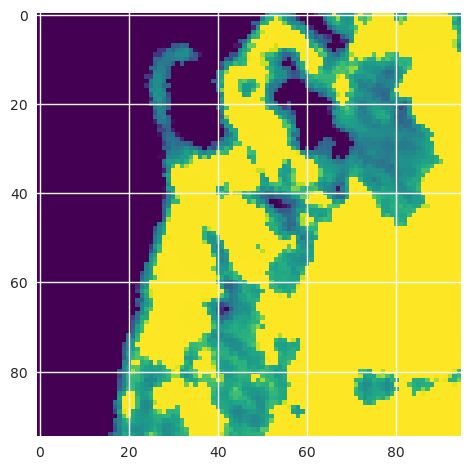

In [1297]:
plt.imshow(reconstruc[:, 100].detach().reshape(95,95), cmap='viridis')
plt.show()

In [1298]:
volume_reg(endmember_init), similarity_reg(logit_endmember_init)

(tensor(59.2881), tensor(0.1501))

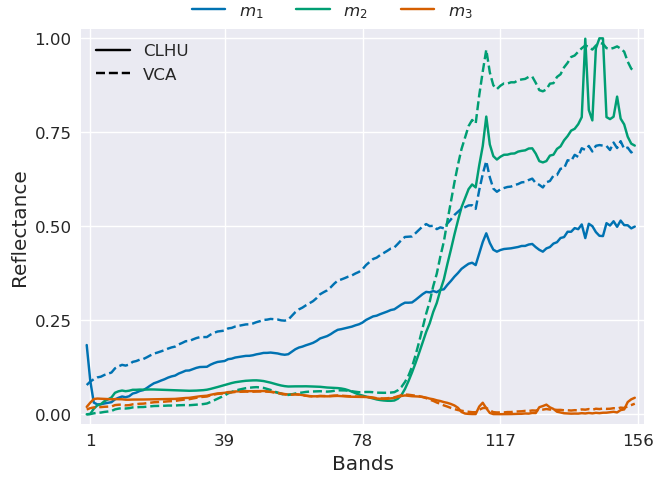

In [1299]:
ebk = torch.sigmoid(model.ebk).detach().cpu()
if endmember_init_method == 'vca':
    label = 'VCA'
else:
    label = 'N-FINDR'
fig = plot_endmembers(ebk, ticks_range=(0, 1), endmember_estimation=[endmember_init], ee_labels=['CLHU',label])
plt.show(fig)
# fig.savefig(os.path.join(result_path, 'clhu/imgs/M_clhu.pdf'), bbox_inches='tight')

# fig = plot_endmembers(ebk, ticks_range=(0, 1))
# plt.show(fig)
# fig.savefig(os.path.join(result_path, 'clhu/imgs/M_clhu_2.pdf'), bbox_inches='tight')

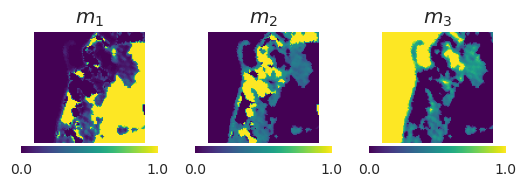

In [1300]:
from torch.nn.functional import softmax
test = softmax(model.A.detach(), dim=1).cpu().numpy().reshape(dataset.n_row, dataset.n_col, -1)

fig = show_abundance(test, transpose=False, cmap='viridis')
plt.show(fig)

# fig.savefig(os.path.join(result_path, 'clhu/imgs/A_clhu_estimation.png'), dpi=300, bbox_inches='tight')

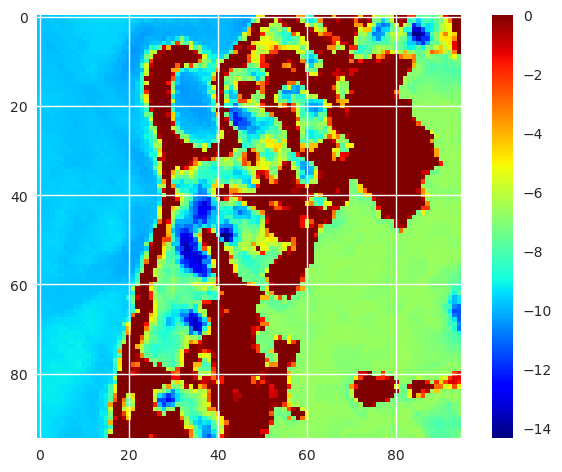

In [1304]:
# test = model._sparse.detach().cpu().numpy().reshape(dataset.n_row, dataset.n_col)
test = model.sparse_gate.variational_parameter().detach().cpu().numpy().reshape(dataset.n_row, dataset.n_col)
test = np.log(test)
plt.imshow(test, cmap='jet')
plt.colorbar()
plt.show()

In [1290]:
test.min()

-14.340783

In [1305]:
model.eval()
X_true = dataset.A @ dataset.endmembers()
# X_true = dataset.X
X_hat = model(dataset.X).detach().cpu()
A_hat = torch.softmax(model.A.detach().cpu(), dim=1)
M_hat = sigmoid(model.ebk.detach().cpu())

_M_hat = model(M_hat).detach().cpu()

import pandas as pd
df = pd.DataFrame(columns=['Method', 'RMSE_X', 'RMSE_A', 'SAD_M'])
df['Method'] = ['CLHU']
df['RMSE_X'] = [rmse(X_true, X_hat, dim=None).numpy()]
df['RMSE_A'] = [rmse(dataset.A, A_hat, dim=None).numpy()]

sad_result = sad(M_hat, dataset.endmembers()).numpy()
# sad_result = sad(_M_hat, dataset.endmembers()).numpy()

df['SAD_M'] = np.diagonal(sad_result).mean()

# df.to_csv(os.path.join(result_path, 'clhu/metrics.csv'), index=False)
print(np.diagonal(sad(_M_hat, dataset.endmembers()).numpy()).mean())
df

0.1523828


,Method,RMSE_X,RMSE_A,SAD_M
0,CLHU,0.041330762,0.14710304,0.152383


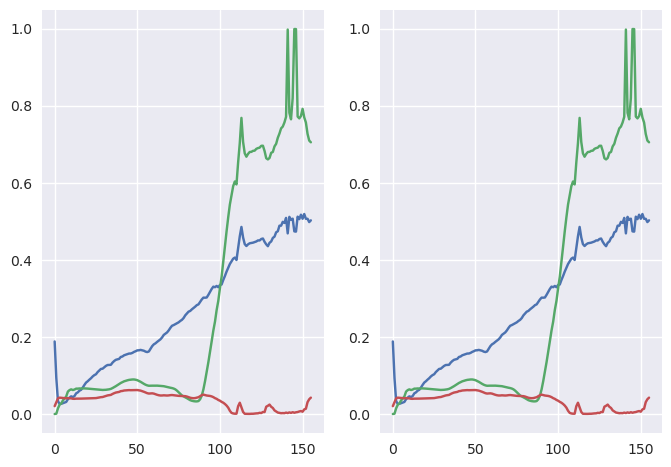

In [1141]:
plt.subplot(1,2,1)
plt.plot(M_hat.detach().cpu().numpy().T)
plt.subplot(1,2,2)
plt.plot(_M_hat.detach().cpu().numpy().T)
plt.show()

# ...

In [ ]:
from HySpecLab.metrics import rmse
from torch import sigmoid
def test(model, dataset):
    X = dataset.X
    model.eval()
    model = model.cpu()
    
    X_true = dataset.A @ dataset.endmembers()
    with torch.no_grad():
        X_hat = model(dataset.X)
        A_hat = torch.softmax(model.A, dim=1)
        M_hat = sigmoid(model.ebk) 
    
    rmse_x = rmse(X_true, X_hat, dim=None).numpy()      
    rmse_a = rmse(dataset.A, A_hat, dim=None).numpy()
    sad_m = np.diagonal(sad(M_hat, dataset.endmembers()).numpy()).mean()
    return rmse_x.item(), rmse_a.item(), sad_m

In [ ]:
from HySpecLab.unmixing import ContrastiveUnmixing

n_bands = dataset.n_bands

batch_rmse_x = []
batch_rmse_a = []
batch_sad_m = []
for i in range(10):
    model = ContrastiveUnmixing(n_bands, n_endmembers, endmember_init=logit_endmember_init)
    train(model, n_endmembers, dataset, n_batchs=50, n_epochs=50, lr=1e-3, similarity_weight=1, simplex_weight=1e-2)

    rmse_x, rmse_a, sad_m = test(model, dataset)
    batch_rmse_x.append(rmse_x)
    batch_rmse_a.append(rmse_a)
    batch_sad_m.append(sad_m)

    print(rmse_x, rmse_a, sad_m)

In [ ]:
# generate dataframe
import pandas as pd
df = pd.DataFrame(columns=['RMSE_X', 'RMSE_A', 'SAD_M'])
df['RMSE_X'] = batch_rmse_x
df['RMSE_A'] = batch_rmse_a
df['SAD_M'] = batch_sad_m

# extract mean and std
df['RMSE_X'].mean(), df['RMSE_X'].std(), df['RMSE_A'].mean(), df['RMSE_A'].std(), df['SAD_M'].mean(), df['SAD_M'].std()

In [ ]:
df.to_csv(os.path.join(result_path, 'clhu/metrics_{}_batch.csv'.format(endmember_init_method)), index=False)